In [ ]:
import pandas as pd
import numpy as np
from google.cloud import storage
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
bucket_name = 'data_housee'

# load preprocessed data
train_df = pd.read_parquet(f'gs://{bucket_name}/wildfire_ml/train_data.parquet')
test_df = pd.read_parquet(f'gs://{bucket_name}/wildfire_ml/test_data.parquet')

# load preprocessing artifacts
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob('wildfire_ml/preprocessing_artifacts.pkl')
blob.download_to_filename('preprocessing_artifacts.pkl')
artifacts = joblib.load('preprocessing_artifacts.pkl')

# important info
selected_features = artifacts['selected_features']
scaler = artifacts['scaler']
optimal_n_features = artifacts['optimal_n_features']

print(f"Loaded {len(train_df)} training samples and {len(test_df)} test samples")
print(f"Using {optimal_n_features} optimal features selected by elbow method")
print(f"Features: {selected_features}")

Loaded 5803627 training samples and 1450907 test samples
Using 27 optimal features selected by elbow method
Features: ['longitude', 'prefire_fuel', 'cwd_frac', 'duff_frac', 'day_of_year_sin', 'fm1000_value', 'srad_value', 'day_of_year_cos', 'bi_value', 'fm100_value', 'rmax_value', 'month', 'season', 'covertype', 'th_value', 'latitude', 'burn_source', 'rmin_value', 'vs_value', 'burnday_source', 'vpd_value', 'pet_value', 'sph_value', 'BSEV', 'tmmn_value', 'fuelcode', 'fuel_moisture_class']


In [ ]:
# separate features & target
X_train = train_df.drop('duration', axis=1)
y_train = train_df['duration']
X_test = test_df.drop('duration', axis=1)
y_test = test_df['duration']

# verify we have the right features
assert list(X_train.columns) == selected_features, "Feature mismatch!"

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Target statistics:")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  Test - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

X_train shape: (5803627, 27)
X_test shape: (1450907, 27)
Target statistics:
  Train - Mean: 7.76, Std: 11.93
  Test - Mean: 7.76, Std: 12.00


In [ ]:
# sample data for faster initial comparisons
sample_size = min(50000, len(X_train))
sample_idx = np.random.choice(X_train.index, sample_size, replace=False)

X_train_sample = X_train.loc[sample_idx]
y_train_sample = y_train.loc[sample_idx]

val_size = min(10000, len(X_test))
val_idx = np.random.choice(X_test.index, val_size, replace=False)

X_val_sample = X_test.loc[val_idx]
y_val_sample = y_test.loc[val_idx]

# drop NaNs from both training and validation samples (these were the 2022 datapoints I forgot)
original_train_rows = len(X_train_sample)
original_val_rows = len(X_val_sample)

X_train_sample = X_train_sample.dropna()
y_train_sample = y_train_sample.loc[X_train_sample.index]

X_val_sample = X_val_sample.dropna()
y_val_sample = y_val_sample.loc[X_val_sample.index]

# Report dropped rows
print(f"Sample sizes - Train: {len(X_train_sample)} (dropped {original_train_rows - len(X_train_sample)}), "
      f"Validation: {len(X_val_sample)} (dropped {original_val_rows - len(X_val_sample)})")


In [ ]:
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

print("Running LazyPredict comparison on sample data...")

lazy_reg = LazyRegressor(
    verbose=0,
    ignore_warnings=True,
    custom_metric=None,
    predictions=False
)

models_results, predictions = lazy_reg.fit(
    X_train_sample, X_val_sample,
    y_train_sample, y_val_sample
)


print("\nTop 10 Models by R-Squared:")
print(models_results.head(10))

models_results.to_csv('lazypredict_results_sample.csv')
print("\nResults saved to 'lazypredict_results_sample.csv'")

plt.figure(figsize=(12, 8))
top_models = models_results.head(15)
plt.barh(top_models.index, top_models['R-Squared'])
plt.xlabel('R-Squared Score')
plt.title('Model Performance Comparison (LazyPredict - Top 15 Models on Sample)')
plt.tight_layout()
plt.show()



Running LazyPredict comparison on sample data...


  0%|          | 0/42 [00:00<?, ?it/s]


Running custom model comparison...
Training RandomForestRegressor...
Training XGBRegressor...
Training HistGradientBoostingRegressor...
Training GradientBoostingRegressor...
Training LassoCV...
Training RidgeCV...
Training ElasticNetCV...
Training KNeighborsRegressor...
Training DecisionTreeRegressor...
Training MLPRegressor...

Custom Model Comparison Results:
                               R-Squared       RMSE       MAE  Time Taken
Model                                                                    
RandomForestRegressor           0.680967   6.561582  2.892333  137.024377
XGBRegressor                    0.603847   7.311763  3.899940    1.199317
HistGradientBoostingRegressor   0.585124   7.482560  4.132735    0.950014
GradientBoostingRegressor       0.408860   8.931742  5.221498   29.086687
MLPRegressor                    0.378412   9.158877  5.618564   80.470575
KNeighborsRegressor             0.360407   9.290579  4.559936    0.014122
DecisionTreeRegressor           0.317829   

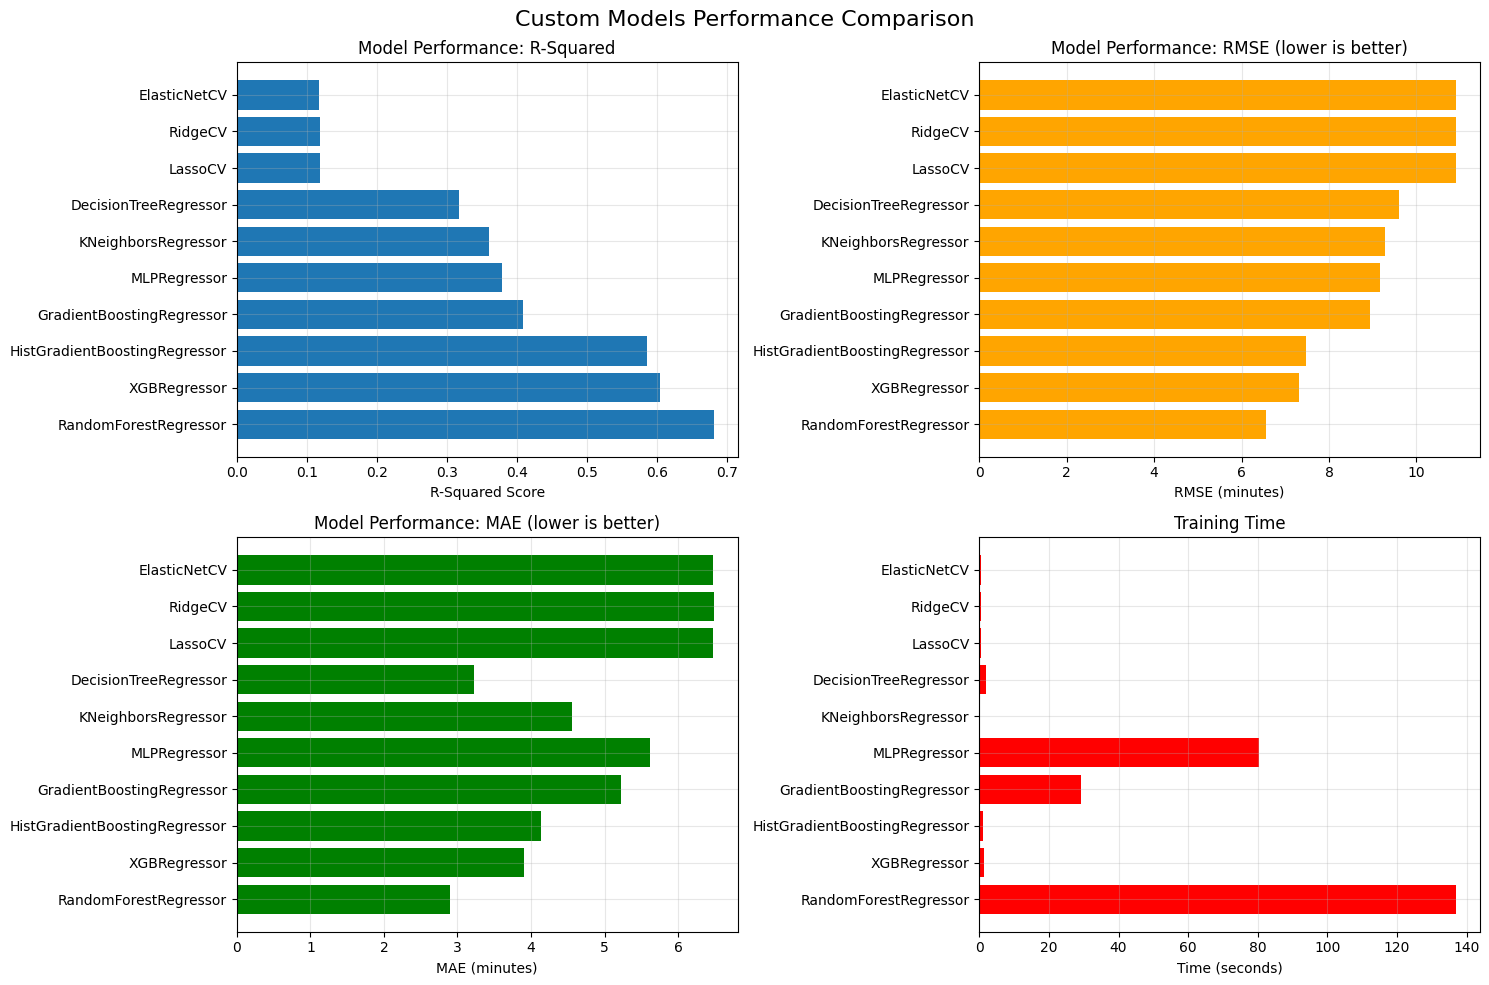


BEST MODEL SUMMARY
Best Model: RandomForestRegressor
R-Squared: 0.6810
RMSE: 6.56 minutes
MAE: 2.89 minutes
Training Time: 137.02 seconds


In [ ]:
import time


print("\n" + "="*50)
print("Running custom model comparison...")
print("="*50)

from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
)
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor


try:
    from xgboost import XGBRegressor
    has_xgboost = True
except ImportError:
    has_xgboost = False
    print("XGBoost not installed. Skipping XGBRegressor.")

#  models
custom_models = {
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(verbosity=0, n_jobs=1, random_state=42) if has_xgboost else None,
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'LassoCV': LassoCV(cv=5),
    'RidgeCV': RidgeCV(cv=5),
    'ElasticNetCV': ElasticNetCV(cv=5),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(max_iter=300, random_state=42)
}

custom_models = {k: v for k, v in custom_models.items() if v is not None}

results = []

for name, model in custom_models.items():
    print(f"Training {name}...")

    start_time = time.time()
    model.fit(X_train_sample, y_train_sample)
    train_time = time.time() - start_time
    y_pred = model.predict(X_val_sample)

    r2 = r2_score(y_val_sample, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_sample, y_pred))
    mae = mean_absolute_error(y_val_sample, y_pred)

    results.append({
        'Model': name,
        'R-Squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Time Taken': train_time
    })

custom_results_df = pd.DataFrame(results)
custom_results_df = custom_results_df.sort_values('R-Squared', ascending=False)
custom_results_df = custom_results_df.set_index('Model')

print("\nCustom Model Comparison Results:")
print(custom_results_df)

custom_results_df.to_csv('custom_model_comparison.csv')
print("\nCustom results saved to 'custom_model_comparison.csv'")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].barh(custom_results_df.index, custom_results_df['R-Squared'])
axes[0, 0].set_xlabel('R-Squared Score')
axes[0, 0].set_title('Model Performance: R-Squared')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].barh(custom_results_df.index, custom_results_df['RMSE'], color='orange')
axes[0, 1].set_xlabel('RMSE (minutes)')
axes[0, 1].set_title('Model Performance: RMSE (lower is better)')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].barh(custom_results_df.index, custom_results_df['MAE'], color='green')
axes[1, 0].set_xlabel('MAE (minutes)')
axes[1, 0].set_title('Model Performance: MAE (lower is better)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].barh(custom_results_df.index, custom_results_df['Time Taken'], color='red')
axes[1, 1].set_xlabel('Time (seconds)')
axes[1, 1].set_title('Training Time')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Custom Models Performance Comparison', fontsize=16)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("BEST MODEL SUMMARY")
print("="*50)
best_model_name = custom_results_df.index[0]
print(f"Best Model: {best_model_name}")
print(f"R-Squared: {custom_results_df.loc[best_model_name, 'R-Squared']:.4f}")
print(f"RMSE: {custom_results_df.loc[best_model_name, 'RMSE']:.2f} minutes")
print(f"MAE: {custom_results_df.loc[best_model_name, 'MAE']:.2f} minutes")
print(f"Training Time: {custom_results_df.loc[best_model_name, 'Time Taken']:.2f} seconds")